# Model v10

This model was trained and tested with images validated to contain a path (second round of validation).

Roughness metric = k-means 4.

## Set-up

In [ ]:
!pip install wandb

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 50.7MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/My Drive/Labeling/Model/'

ImageFolder.ipynb  Images  Models.gdoc	Previous  v8  v9


In [ ]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [ ]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-2')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model with `get_transforms(do_flip=False)`

#### Load data

In [ ]:
path = '/gdrive/My Drive/Labeling/Model'
df = pd.read_csv('/gdrive/My Drive/Labeling/LabelsCSV/random_split/Metric1/all_labels_path_train.csv')
df = df.filter(items=['image', 'group_4'])
df['group_4'] = df['group_4'].astype(int).astype(str)
df.head()

,image,group_4
0,969902383s228ms.jpg,2
1,969902516s227ms.jpg,1
2,969902832s243ms.jpg,0
3,970330409s202ms.jpg,0
4,969901887s232ms.jpg,0


In [ ]:
image_path = os.path.join(path, 'Images')

print('All images:', len(os.listdir(image_path)))
print('Images in Labeling/PathDetectionClassifier/PredictImages/Path:', len(os.listdir('/gdrive/My Drive/Labeling/PathDetectionClassifier/PredictImages/Path')))
print('Images with labels in CSV (should be 80% of the images in the Path folder):', len(df))

All images: 8983
Images in Labeling/PathDetectionClassifier/PredictImages/Path: 7070
Images with labels in CSV (should be 80% of the images in the Path folder): 5656


#### Balance classes

In [ ]:
group_0 = df[df['group_4'] == '0']
group_1 = df[df['group_4'] == '1']
group_2 = df[df['group_4'] == '2']
group_3 = df[df['group_4'] == '3']

print(len(group_0))
print(len(group_1))
print(len(group_2))
print(len(group_3))

2227
2101
1012
316


In [ ]:
group_0 = group_0[:1012]
group_1 = group_1[:1012]
group_2 = group_2[:1012]

df_balanced = group_0.append(group_1).append(group_2).append(group_3)

print(len(df_balanced))

print(len(df_balanced[df_balanced['group_4'] == '0']))
print(len(df_balanced[df_balanced['group_4'] == '1']))
print(len(df_balanced[df_balanced['group_4'] == '2']))
print(len(df_balanced[df_balanced['group_4'] == '3']))

3352
1012
1012
1012
316


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [ ]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [ ]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_by_rand_pct(0.2)
        .label_from_df()
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch()
        .normalize())

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

2682 2682
670 670


In [ ]:
print(data.classes)

['0', '1', '2', '3']


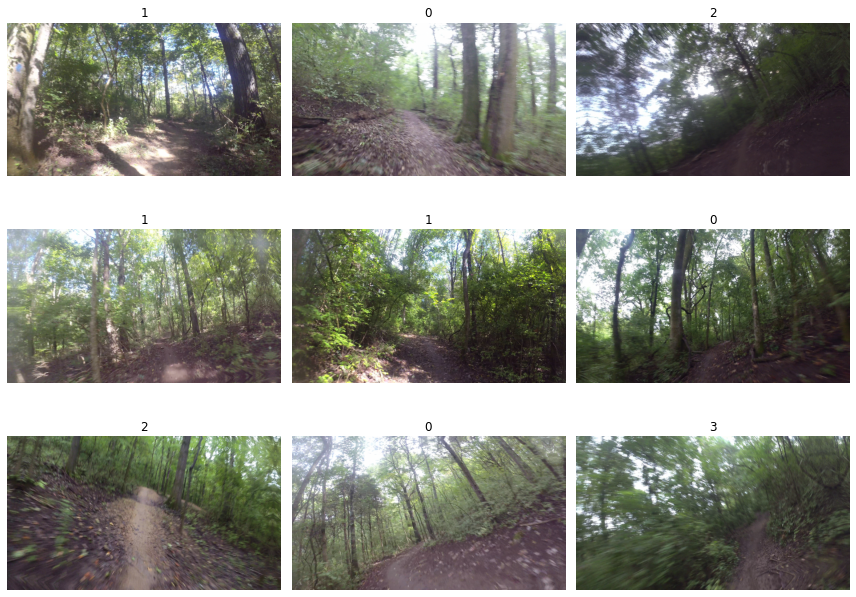

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [ ]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


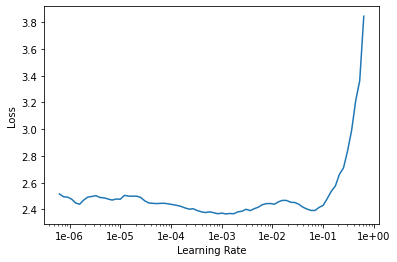

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.001

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.313531,1.775228,0.334328,12:34
1,2.192252,1.732309,0.388060,11:34
2,1.880393,1.435446,0.394030,11:34
3,1.651575,1.366192,0.397015,11:31
4,1.499642,1.341401,0.402985,11:44


Better model found at epoch 0 with valid_loss value: 1.7752281427383423.
Better model found at epoch 1 with valid_loss value: 1.7323087453842163.
Better model found at epoch 2 with valid_loss value: 1.4354459047317505.
Better model found at epoch 3 with valid_loss value: 1.366192102432251.
Better model found at epoch 4 with valid_loss value: 1.3414007425308228.
Loaded best saved model from /content/wandb/run-20201221_220420-2auzpxav/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(path, 'v10/v10-stage-1-rn50'))

In [ ]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.389799,1.398273,0.383582,12:07


Better model found at epoch 0 with valid_loss value: 1.3982725143432617.
Loaded best saved model from /content/wandb/run-20201221_220420-2auzpxav/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(path, 'v10/v10-stage-1-rn50'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

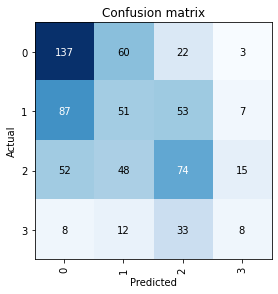

In [ ]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
# bs = 64
bs = 16    # uncomment this line if you run out of memory
learn.data.batch_size = bs

In [ ]:
learn.data.batch_size

16

In [ ]:
learn.load(os.path.join(path, 'v10/v10-stage-1-rn50'))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20201221_220420-2auzpxav/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


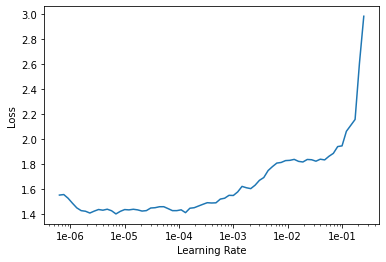

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.507231,1.348448,0.383582,13:30
1,1.475137,1.344400,0.398507,12:17
2,1.397676,1.384532,0.394030,12:33
3,1.387637,1.349442,0.401493,12:28
4,1.325410,1.320935,0.408955,12:26


Better model found at epoch 0 with valid_loss value: 1.3484479188919067.
Better model found at epoch 1 with valid_loss value: 1.3444002866744995.
Better model found at epoch 4 with valid_loss value: 1.3209353685379028.
Loaded best saved model from /content/wandb/run-20201221_220420-2auzpxav/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(path, 'v10/v10-stage-2-rn50'))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
learn.fit_one_cycle(1, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.339132,1.312047,0.426866,13:46


Better model found at epoch 0 with valid_loss value: 1.3120468854904175.
Loaded best saved model from /content/wandb/run-20201221_220420-2auzpxav/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(path, 'v10/v10-stage-2-rn50'))

In [ ]:
learn.fit_one_cycle(1, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.322445,1.337204,0.405970,14:20


Better model found at epoch 0 with valid_loss value: 1.3372044563293457.
Loaded best saved model from /content/wandb/run-20201221_220420-2auzpxav/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(path, 'v10/v10-stage-2-rn50'))

In [ ]:
learn.freeze()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

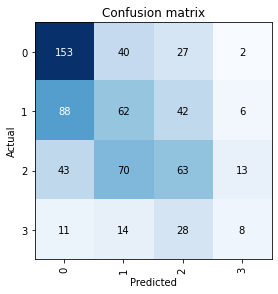

In [ ]:
interp.plot_confusion_matrix()

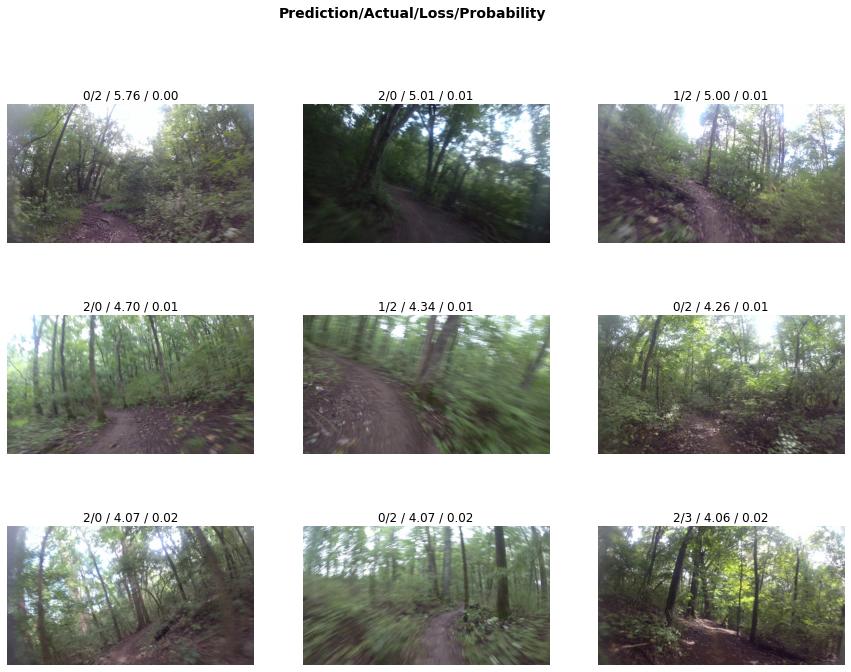

In [ ]:
 interp.plot_top_losses(9, figsize=(15,11))